## Bước 1: Import modules

In [1]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f2cf1cffa96bde50301a3393768ff2212e3996e37ee66faf50657acea6a64a71
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import AutoTokenizer, AutoModelForTokenClassification
from torch.optim import AdamW
from seqeval.metrics import accuracy_score as seqeval_accuracy, f1_score as seqeval_f1, precision_score as seqeval_precision, recall_score as seqeval_recall, classification_report as seqeval_classification_report

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## Bước 2: Dataset Class

In [3]:
# Dataset class cho Transformer
class NERTransformerDataset(Dataset):
    def __init__(self, sentences, tags, tokenizer, tag_to_idx, max_length=128):
        self.sentences = sentences
        self.tags = tags
        self.tokenizer = tokenizer
        self.tag_to_idx = tag_to_idx
        self.max_length = max_length
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tags = self.tags[idx]
        
        # Tokenize - với subword tokenization, cần align tags
        encoding = self.tokenizer(
            sentence,
            is_split_into_words=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Align tags với subword tokens
        word_ids = encoding.word_ids(batch_index=0)
        aligned_tags = []
        previous_word_idx = None
        
        # Padding label id (standard trong transformers: -100 để ignore trong loss)
        pad_token_label_id = -100
        
        for word_idx in word_ids:
            if word_idx is None:
                # Special tokens (CLS, SEP, PAD) - ignore trong loss
                aligned_tags.append(pad_token_label_id)
            elif word_idx != previous_word_idx:
                # First subword token của một word - dùng tag của word đó
                aligned_tags.append(self.tag_to_idx[tags[word_idx]])
            else:
                # Subword token tiếp theo - PHẢI IGNORE (-100) để tránh label noise
                aligned_tags.append(pad_token_label_id)  # -100 để ignore trong loss
            previous_word_idx = word_idx
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(aligned_tags, dtype=torch.long)
        }

## Bước 3: Load và xử lý dữ liệu NER cho tiếng Việt (PhoNER)

In [4]:
def load_phoner_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

# Load train, dev, test data
train_data = load_phoner_data('/kaggle/input/ner-vi/train_word.json')
dev_data = load_phoner_data('/kaggle/input/ner-vi/dev_word.json')
test_data = load_phoner_data('/kaggle/input/ner-vi/test_word.json')

# Extract sentences and tags
train_sentences = []
train_tags = []
for item in train_data:
    train_sentences.append(item['words'])
    train_tags.append(item['tags'])

val_sentences = []
val_tags = []
for item in dev_data:
    val_sentences.append(item['words'])
    val_tags.append(item['tags'])

test_sentences = []
test_tags = []
for item in test_data:
    test_sentences.append(item['words'])
    test_tags.append(item['tags'])

# Tạo tag mappings (chỉ dựa trên training data)
unique_tags = set()
for tag_list in train_tags:
    unique_tags.update(tag_list)

tag_to_idx = {}
for idx, tag in enumerate(sorted(unique_tags)):
    tag_to_idx[tag] = idx

idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

print("NER_VI DATASET")
print("=" * 70)
print(f"Train sentences: {len(train_sentences)}")
print(f"Validation sentences: {len(val_sentences)}")
print(f"Test sentences: {len(test_sentences)}")
print(f"Số lượng tags: {len(tag_to_idx)}")
print(f"Tags: {list(tag_to_idx.keys())}")
print(f"\nVí dụ câu đầu tiên:")
print(f"Words: {train_sentences[0]}")
print(f"Tags: {train_tags[0]}")

NER_VI DATASET
Train sentences: 5027
Validation sentences: 2000
Test sentences: 3000
Số lượng tags: 20
Tags: ['B-AGE', 'B-DATE', 'B-GENDER', 'B-JOB', 'B-LOCATION', 'B-NAME', 'B-ORGANIZATION', 'B-PATIENT_ID', 'B-SYMPTOM_AND_DISEASE', 'B-TRANSPORTATION', 'I-AGE', 'I-DATE', 'I-JOB', 'I-LOCATION', 'I-NAME', 'I-ORGANIZATION', 'I-PATIENT_ID', 'I-SYMPTOM_AND_DISEASE', 'I-TRANSPORTATION', 'O']

Ví dụ câu đầu tiên:
Words: ['Đồng_thời', ',', 'bệnh_viện', 'tiếp_tục', 'thực_hiện', 'các', 'biện_pháp', 'phòng_chống', 'dịch_bệnh', 'COVID', '-', '19', 'theo', 'hướng_dẫn', 'của', 'Bộ', 'Y_tế', '.']
Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O']


## Bước 4: Chuẩn bị dữ liệu và khởi tạo Model

In [5]:
# Config - XLM-RoBERTa hỗ trợ cả tiếng Anh và tiếng Việt
model_name = 'xlm-roberta-base'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Tokenizer và Model
tokenizer = AutoTokenizer.from_pretrained(model_name)
num_labels = len(tag_to_idx)
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)
model = model.to(device)

# Create datasets
max_length = 128
train_dataset = NERTransformerDataset(train_sentences, train_tags, tokenizer, tag_to_idx, max_length)
val_dataset = NERTransformerDataset(val_sentences, val_tags, tokenizer, tag_to_idx, max_length)
test_dataset = NERTransformerDataset(test_sentences, test_tags, tokenizer, tag_to_idx, max_length)

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nTrain size: {len(train_sentences)}")
print(f"Val size: {len(val_sentences)}")
print(f"Test size: {len(test_sentences)}")
print(f"Number of labels: {num_labels}")

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

2025-12-18 11:27:52.465087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766057272.644656      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766057272.694754      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Train size: 5027
Val size: 2000
Test size: 3000
Number of labels: 20


## Bước 5: Huấn luyện Model

In [6]:
# Training setup
optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 20
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_accuracies = []

print(f"\n{'='*70}")
print("TRAINING XLM-ROBERTA MODEL CHO NER_VI")
print(f"{'='*70}\n")

for epoch in range(num_epochs):
    # TRAIN
    model.train()
    train_loss = 0
    train_batches = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # Model tự tính loss khi có labels
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
    
    avg_train_loss = train_loss / train_batches
    train_losses.append(avg_train_loss)
    

    # VALIDATION
    model.eval()
    val_loss = 0
    val_batches = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            val_loss += loss.item()
            val_batches += 1
            
            preds = torch.argmax(logits, dim=-1)  
            
            # Chỉ lấy token không phải padding (-100)
            mask = (labels != -100)
            all_preds.extend(preds[mask].cpu().numpy())
            all_labels.extend(labels[mask].cpu().numpy())
    
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)
    
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_accuracy)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_transformer_ner_model_vi.pth')
        print(f"Epoch {epoch+1}/{num_epochs} - Best model saved!")
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}\n")


TRAINING XLM-ROBERTA MODEL CHO NER_VI



Epoch 1/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.63it/s]


Epoch 1/20 - Best model saved!
Epoch 1/20
Train Loss: 0.4462 | Val Loss: 0.1285 | Val Acc: 0.9664



Epoch 2/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.71it/s]


Epoch 2/20 - Best model saved!
Epoch 2/20
Train Loss: 0.0794 | Val Loss: 0.0844 | Val Acc: 0.9759



Epoch 3/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.67it/s]


Epoch 3/20 - Best model saved!
Epoch 3/20
Train Loss: 0.0513 | Val Loss: 0.0811 | Val Acc: 0.9800



Epoch 4/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.65it/s]


Epoch 4/20
Train Loss: 0.0352 | Val Loss: 0.0812 | Val Acc: 0.9788



Epoch 5/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.61it/s]


Epoch 5/20 - Best model saved!
Epoch 5/20
Train Loss: 0.0282 | Val Loss: 0.0770 | Val Acc: 0.9808



Epoch 6/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.59it/s]


Epoch 6/20
Train Loss: 0.0256 | Val Loss: 0.0792 | Val Acc: 0.9818



Epoch 7/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.67it/s]


Epoch 7/20
Train Loss: 0.0198 | Val Loss: 0.0849 | Val Acc: 0.9812



Epoch 8/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.61it/s]


Epoch 8/20
Train Loss: 0.0172 | Val Loss: 0.0920 | Val Acc: 0.9813



Epoch 9/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.58it/s]


Epoch 9/20
Train Loss: 0.0185 | Val Loss: 0.0842 | Val Acc: 0.9818



Epoch 10/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.65it/s]


Epoch 10/20
Train Loss: 0.0133 | Val Loss: 0.0896 | Val Acc: 0.9824



Epoch 11/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.61it/s]


Epoch 11/20
Train Loss: 0.0138 | Val Loss: 0.0929 | Val Acc: 0.9810



Epoch 12/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.60it/s]


Epoch 12/20
Train Loss: 0.0118 | Val Loss: 0.0984 | Val Acc: 0.9813



Epoch 13/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.60it/s]


Epoch 13/20
Train Loss: 0.0086 | Val Loss: 0.1001 | Val Acc: 0.9822



Epoch 14/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.64it/s]


Epoch 14/20
Train Loss: 0.0080 | Val Loss: 0.1164 | Val Acc: 0.9808



Epoch 15/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.65it/s]


Epoch 15/20
Train Loss: 0.0138 | Val Loss: 0.0957 | Val Acc: 0.9798



Epoch 16/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.61it/s]


Epoch 16/20
Train Loss: 0.0113 | Val Loss: 0.1041 | Val Acc: 0.9819



Epoch 17/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.58it/s]


Epoch 17/20
Train Loss: 0.0060 | Val Loss: 0.1018 | Val Acc: 0.9803



Epoch 18/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.64it/s]


Epoch 18/20
Train Loss: 0.0065 | Val Loss: 0.1059 | Val Acc: 0.9820



Epoch 19/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.65it/s]


Epoch 19/20
Train Loss: 0.0055 | Val Loss: 0.1098 | Val Acc: 0.9816



Epoch 20/20 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.59it/s]


Epoch 20/20
Train Loss: 0.0059 | Val Loss: 0.1049 | Val Acc: 0.9828



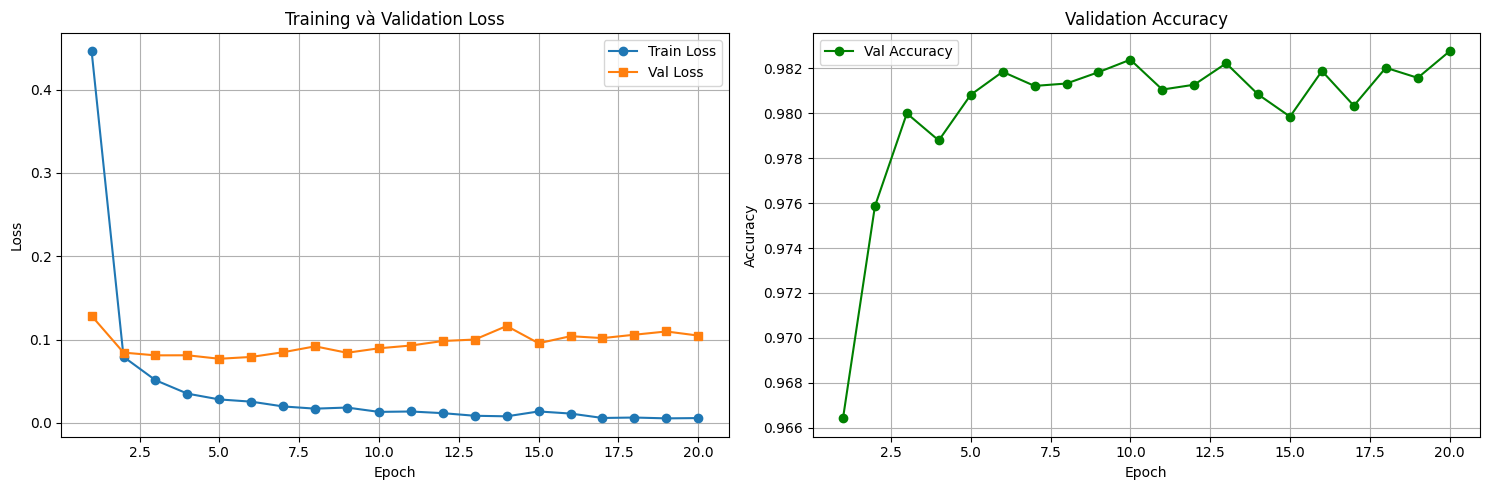

In [7]:
# Visualization: Loss và Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
ax1.plot(range(1, num_epochs+1), val_losses, label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training và Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy', marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Bước 6: Đánh giá mô hình

In [8]:
# Evaluation trên test set
model.load_state_dict(torch.load('best_transformer_ner_model_vi.pth'))
model.eval()

all_preds = []
all_labels = []
all_preds_sequences = []  # Cho seqeval: list of sequences
all_labels_sequences = []  # Cho seqeval: list of sequences

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        
        # Process từng sequence trong batch để tạo sequences cho seqeval
        batch_size = input_ids.shape[0]
        for i in range(batch_size):
            # Lấy mask cho sequence này (ignore -100 và padding)
            seq_mask = (labels[i] != -100).cpu().numpy()
            
            # Convert predictions và labels thành tag names cho seqeval
            seq_preds = [idx_to_tag[pred.item()] for pred, mask_val in zip(preds[i], seq_mask) if mask_val]
            seq_labels = [idx_to_tag[label.item()] for label, mask_val in zip(labels[i], seq_mask) if mask_val]
            
            if len(seq_preds) > 0 and len(seq_labels) > 0:
                all_preds_sequences.append(seq_preds)
                all_labels_sequences.append(seq_labels)
            
            # Token-level predictions (cho token accuracy)
            all_preds.extend(preds[i][seq_mask].cpu().numpy())
            all_labels.extend(labels[i][seq_mask].cpu().numpy())

Evaluating: 100%|██████████| 188/188 [00:14<00:00, 12.68it/s]


In [9]:
# ==========================================
# ENTITY-LEVEL METRICS (seqeval) - CHUẨN CHO NER
# ==========================================
entity_f1 = seqeval_f1(all_labels_sequences, all_preds_sequences)
entity_precision = seqeval_precision(all_labels_sequences, all_preds_sequences)
entity_recall = seqeval_recall(all_labels_sequences, all_preds_sequences)
entity_accuracy = seqeval_accuracy(all_labels_sequences, all_preds_sequences)

print("=" * 70)
print("ENTITY-LEVEL METRICS (seqeval) - CHUẨN CHO NER")
print("=" * 70)
print(f"Entity F1-Score: {entity_f1:.4f}")
print(f"Entity Precision: {entity_precision:.4f}")
print(f"Entity Recall: {entity_recall:.4f}")
print(f"Entity Accuracy: {entity_accuracy:.4f}")
print("\n" + "=" * 70)
print("ENTITY-LEVEL CLASSIFICATION REPORT")
print("=" * 70)
print(seqeval_classification_report(all_labels_sequences, all_preds_sequences, digits=4))

# ==========================================
# TOKEN-LEVEL METRICS 
# ==========================================
accuracy_micro = accuracy_score(all_labels, all_preds)
f1_micro = f1_score(all_labels, all_preds, average='micro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

# Tính cho từng tag
tag_names = [idx_to_tag[i] for i in range(num_labels)]
tag_accuracies = []
tag_f1_scores = []

for tag_idx in range(num_labels):
    tag_mask = [label == tag_idx for label in all_labels]
    num_tag_samples = sum(tag_mask)
    
    if num_tag_samples > 0:
        correct = sum([all_labels[i] == all_preds[i] for i in range(len(all_labels)) if tag_mask[i]])
        tag_acc = correct / num_tag_samples
        
        binary_labels = [1 if label == tag_idx else 0 for label in all_labels]
        binary_preds = [1 if pred == tag_idx else 0 for pred in all_preds]
        tag_f1 = f1_score(binary_labels, binary_preds, zero_division=0)
    else:
        tag_acc = 0.0
        tag_f1 = 0.0
    
    tag_accuracies.append(tag_acc)
    tag_f1_scores.append(tag_f1)

accuracy_macro = np.mean(tag_accuracies)

# Kết quả TOKEN-LEVEL (chỉ để tham khảo)
print("\n" + "=" * 70)
print("TOKEN-LEVEL METRICS (chỉ để tham khảo, không phải metric chính)")
print("=" * 70)
print(f"Token Accuracy (Micro): {accuracy_micro:.4f}")
print(f"Token Accuracy (Macro): {accuracy_macro:.4f}")
print(f"Token F1-Score (Micro): {f1_micro:.4f}")
print(f"Token F1-Score (Macro): {f1_macro:.4f}")

# Xuất kết quả cho từng nhãn thực thể
results_df = pd.DataFrame({
    'Tag': tag_names,
    'Accuracy': [f'{acc:.4f}' for acc in tag_accuracies],
    'F1-Score': [f'{f1:.4f}' for f1 in tag_f1_scores]
})

print("\n" + "=" * 70)
print("KẾT QUẢ CHI TIẾT THEO TỪNG NHÃN THỰC THỂ")
print("=" * 70)
print(results_df.to_string(index=False))

# Classification Report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(all_labels, all_preds, target_names=tag_names, digits=4))

ENTITY-LEVEL METRICS (seqeval) - CHUẨN CHO NER
Entity F1-Score: 0.9293
Entity Precision: 0.9164
Entity Recall: 0.9426
Entity Accuracy: 0.9774

ENTITY-LEVEL CLASSIFICATION REPORT
                     precision    recall  f1-score   support

                AGE     0.9404    0.9753    0.9575       566
               DATE     0.9819    0.9909    0.9864      1641
             GENDER     0.9643    0.9664    0.9654       447
                JOB     0.4816    0.6821    0.5646       173
           LOCATION     0.9356    0.9320    0.9338      4396
               NAME     0.9073    0.9221    0.9147       308
       ORGANIZATION     0.7702    0.9087    0.8337       767
         PATIENT_ID     0.9790    0.9795    0.9792      1951
SYMPTOM_AND_DISEASE     0.8254    0.8915    0.8571      1124
     TRANSPORTATION     0.9242    0.9482    0.9361       193

          micro avg     0.9164    0.9426    0.9293     11566
          macro avg     0.8710    0.9197    0.8928     11566
       weighted avg     0.9

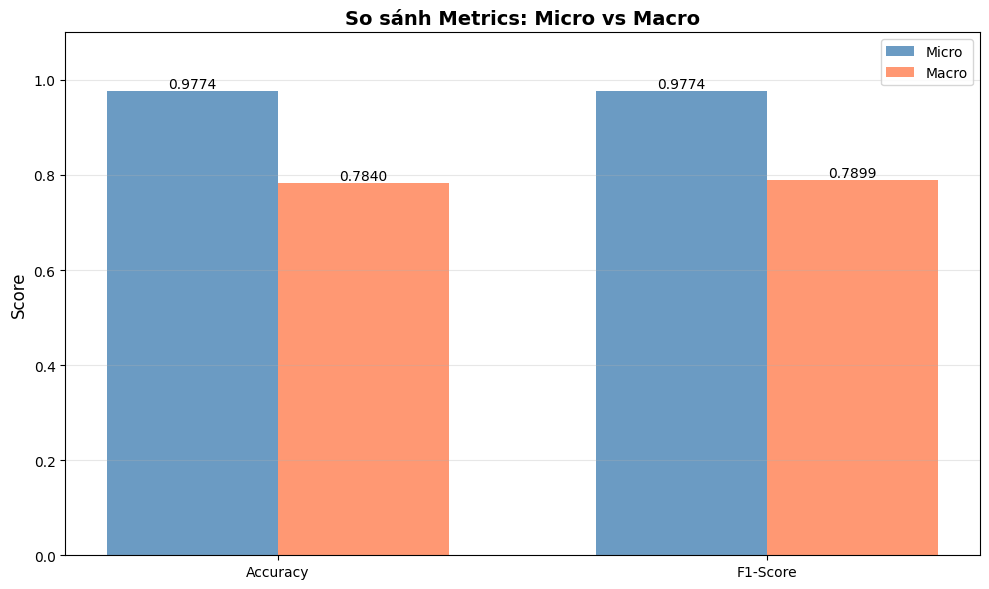

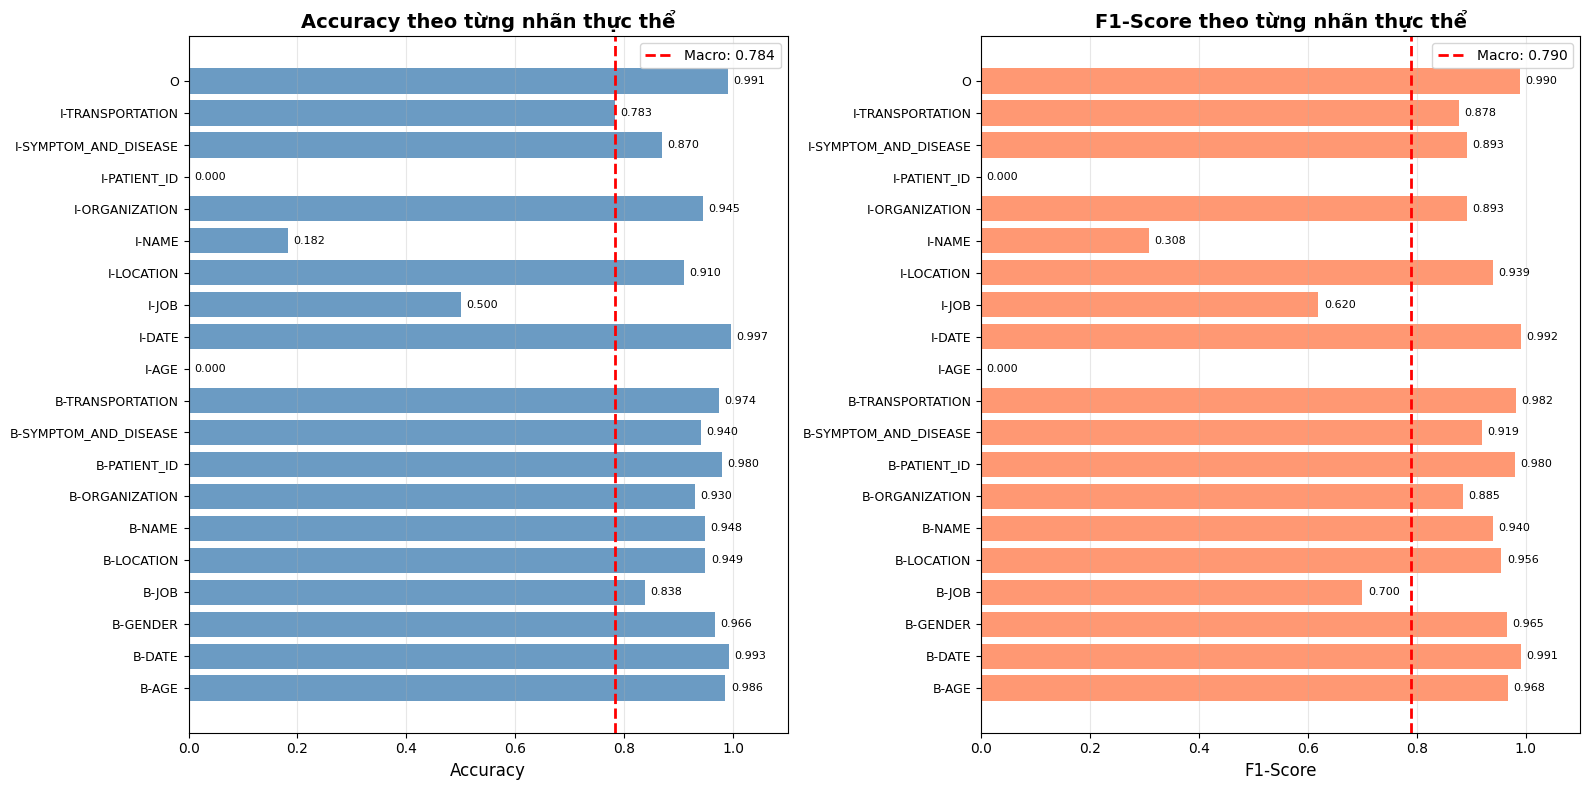

In [10]:
# Visualization: So sánh Micro vs Macro
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['Accuracy', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, [accuracy_micro, f1_micro], width, label='Micro', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, [accuracy_macro, f1_macro], width, label='Macro', alpha=0.8, color='coral')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}',
                ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('So sánh Metrics: Micro vs Macro', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization: Kết quả theo từng tag
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
x_pos = np.arange(len(tag_names))

# Bar chart Accuracy
bars1 = ax1.barh(x_pos, tag_accuracies, alpha=0.8, color='steelblue')
ax1.set_yticks(x_pos)
ax1.set_yticklabels(tag_names, fontsize=9)
ax1.set_xlabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy theo từng nhãn thực thể', fontsize=14, fontweight='bold')
ax1.set_xlim([0, 1.1])
ax1.axvline(x=accuracy_macro, color='red', linestyle='--', linewidth=2, label=f'Macro: {accuracy_macro:.3f}')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Thêm giá trị trên các cột
for i, (bar, acc) in enumerate(zip(bars1, tag_accuracies)):
    width = bar.get_width()
    ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{acc:.3f}', ha='left', va='center', fontsize=8)

# Bar chart F1-Score
bars2 = ax2.barh(x_pos, tag_f1_scores, alpha=0.8, color='coral')
ax2.set_yticks(x_pos)
ax2.set_yticklabels(tag_names, fontsize=9)
ax2.set_xlabel('F1-Score', fontsize=12)
ax2.set_title('F1-Score theo từng nhãn thực thể', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1.1])
ax2.axvline(x=f1_macro, color='red', linestyle='--', linewidth=2, label=f'Macro: {f1_macro:.3f}')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

# Thêm giá trị trên các cột
for i, (bar, f1) in enumerate(zip(bars2, tag_f1_scores)):
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{f1:.3f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()

## Bước 7: Lưu model

In [11]:
torch.save(model.state_dict(), 'transformer_ner_vi_final.pth')
print("Model saved!")

Model saved!
